In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from pywbm.water_balance_jax import *

### Read climate data

In [2]:
# Read sample climate data: pre-processed GMFD observations
# containing daily precipitation and temperature from 1948-2008.
ds = xr.open_dataset('../data/conus.nc')

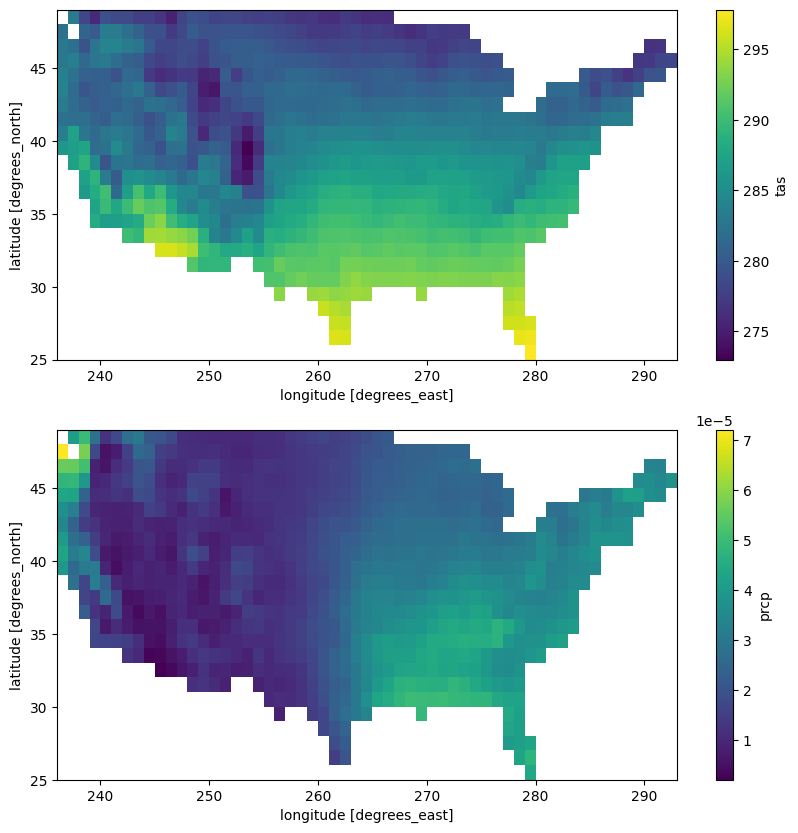

In [3]:
# Take a look at the long term averages
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
ds['tas'].mean(dim='time').plot(ax=axs[0])
ds['prcp'].mean(dim='time').plot(ax=axs[1])
plt.show()

### Simple simulation: constant soil parameters

The strategy for running pyWBM across space is to leverage JAX's native vectorization using the `vmap` function (https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html). Since pyWBM contains no lateral flow of water, we can simulate each pixel independently. `vmap` allows us to run the model across space in a vectorized manner, which is much faster than looping over each pixel. In order to do so, we need to take the 3-dimensional forcing data (lat/lon/time) and collapse (or stack) the two spatial dimensions into one, which provides `vmap` with a single axis to vectorize over. Similarly, for the other inputs to the model--be they parameters or initial conditions--we need to ensure that their spatial dimensions are collapsed into a single axis of the correct size. Then, after running the model, we can reshape or unstack the output back into the original dimensions.

Note that we could also use `pmap` (https://jax.readthedocs.io/en/latest/_autosummary/jax.pmap.html) here in order to parallelize this operation. This could be explored in future.

In [7]:
# Stack using xarray's stack method
ds_stacked = ds.stack(points=['latitude', 'longitude'])

tas_stacked = ds_stacked['tas'].to_numpy().T
tas_stacked = tas_stacked - 273.15 # K -> C

prcp_stacked = ds_stacked['prcp'].to_numpy().T 
prcp_stacked = prcp_stacked * 86400 # kgm/s -> mm/day

# Dimension of the simulation
nx = ds['longitude'].size
ny = ds['latitude'].size
nxy = nx * ny
nt = ds['time'].size

In [8]:
## Read LAI
# For this simple example, we will use a climatology of LAI which is constant over space. 
# If we have LAI as a .nc file, we would stack it in the same way as we did for tas and prcp.
lai = np.loadtxt("../data/mclean_county_daily_lai_climatology.csv")

In [9]:
## Define some parameters for a test simulation
# Here we are going to use spatially constant values for the parameters. So, we define them
# here as floats, and then tile them to the correct spatial axis length `nxy`.
Ts = -1.0
Tm = 1.0
awCap = 300.0
wiltingp = 120.0
rootDepth = 1.0
alpha = 5.5
betaHBV = 3.4

# Construct input dicts
theta = {
    "awCap": np.tile(awCap, nxy), 
    "wiltingp": np.tile(wiltingp, nxy),
    "alpha": np.tile(alpha, nxy),
    "betaHBV": np.tile(betaHBV, nxy),
}

constants = {
    "Ts": np.tile(Ts, nxy),
    "Tm": np.tile(Tm, nxy),
    "rootDepth": np.tile(rootDepth, nxy),
    "phi": ds_stacked['latitude'].to_numpy(), # note this one is different because there is some spatial variation
}

params = {**theta, **constants}

In [10]:
## Forcing
# PET scaling timeseries
Kmin = 0.3
Kmax = 1.2
c_lai = 0.7

Kpet = construct_Kpet_gen(Kmin, Kmax, c_lai, lai)

# The forcing dict contains tas and prcp, which we have already handled, as well as Kpet and LAI, which are defined via
# their climatologies (ie only 365 days). pyWBM expects these inputs to have a time dimension of 365, so here we only need
# to tile them to the correct spatial dimension.
forcing = {
    "tas": tas_stacked,
    "prcp": prcp_stacked,
    "Kpet": np.tile(Kpet, nxy).reshape(nxy, 365),
    "lai": np.tile(lai, nxy).reshape(nxy, 365),
}

In [11]:
# Initial conditions are again constant
init = {
    "Ws_init": np.tile(250.0, nxy),
    "Wi_init": np.tile(0.0, nxy),
    "Sp_init": np.tile(0.0, nxy),
}

In [12]:
%%time
# Make the vmap function
run_water_balance_vmap = jax.jit(
    jax.vmap(run_water_balance, in_axes=(0, 0, 0), out_axes=0)
)

# Run the simulation
out = run_water_balance_vmap(forcing, init, params)

CPU times: user 3.06 s, sys: 1.39 s, total: 4.45 s
Wall time: 2.53 s


In [13]:
# Add outputs to the stacked array and then unstack
ds_stacked['soilMoist'] = (('points', 'time'), out)
ds_out = ds_stacked.unstack('points')

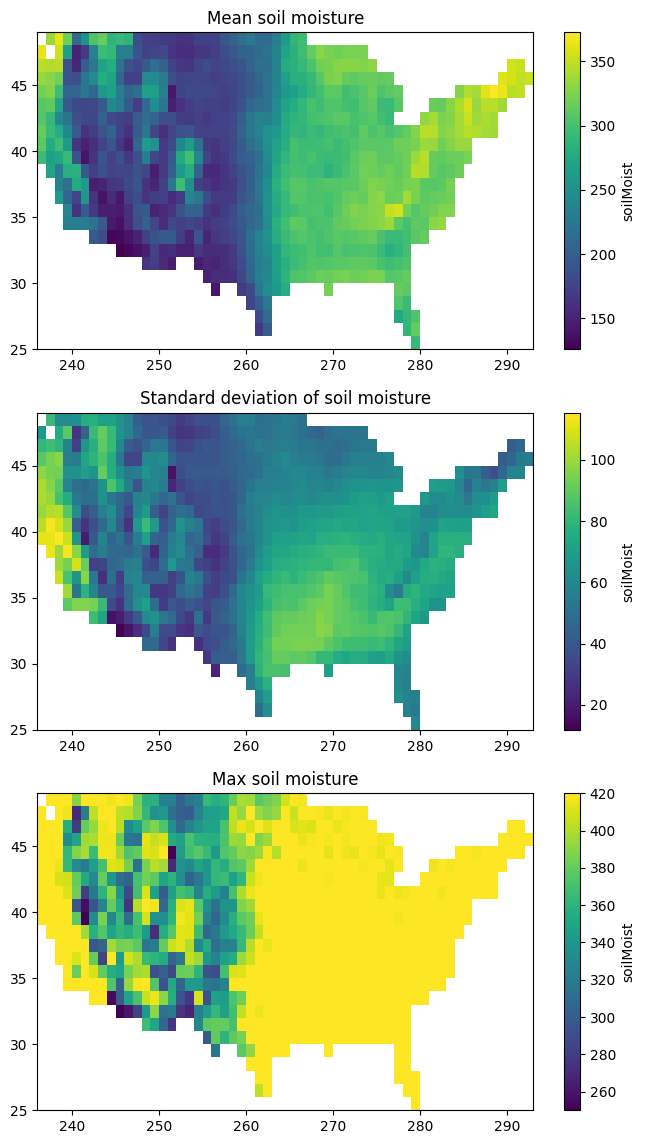

In [14]:
# Plot some summary statistics
fig, axs = plt.subplots(3, 1, figsize=(8, 14))

ds_out['soilMoist'].mean(dim='time', skipna=False).plot(ax=axs[0])
axs[0].set_title('Mean soil moisture')

ds_out['soilMoist'].std(dim='time', skipna=False).plot(ax=axs[1])
axs[1].set_title('Standard deviation of soil moisture')

ds_out['soilMoist'].max(dim='time', skipna=False).plot(ax=axs[2])
axs[2].set_title('Max soil moisture')

for ax in axs:
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.show()

You can see here that since the only spatial variation comes from the climate drivers, the soil moisture patterns are closely related. In reality, there is more variation due to soil properties, topography, vegetation, hydrologic parameters, etc, which will be explored soon.

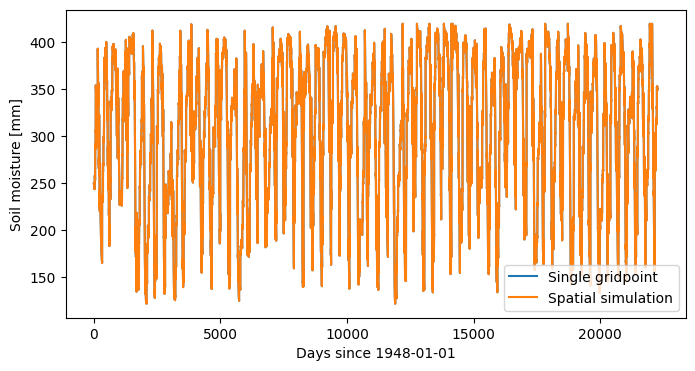

In [15]:
# Let's verify that the spatial simulation gives the same result as the point simulation.

# Choose a test gridpoint
lat_isel = 12
lon_isel = 30


# Set up single gridpoint simulation with same parameters
params = {
    "awCap": awCap,
    "wiltingp": wiltingp,
    "alpha": alpha,
    "betaHBV": betaHBV,
    "Ts": Ts,
    "Tm": Tm,
    "rootDepth": rootDepth,
    "phi": ds.isel(latitude=lat_isel, longitude=lon_isel)['latitude'].to_numpy(),
}

forcing = {
    "tas": ds.isel(latitude=lat_isel, longitude=lon_isel)['tas'].to_numpy() - 273.15,
    "prcp": ds.isel(latitude=lat_isel, longitude=lon_isel)['prcp'].to_numpy() * 86400,
    "Kpet": Kpet,
    "lai": lai,
}

init = {
    "Ws_init": 250.0,
    "Wi_init": 0.0,
    "Sp_init": 0.0,
}

# Simulate soil moisture: single gridpoint
soilM_test = run_water_balance(
    forcing=forcing,
    init=init,
    params=params,
)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(soilM_test, label='Single gridpoint')
ax.plot(ds_out['soilMoist'].isel(latitude=lat_isel, longitude=lon_isel), label='Spatial simulation')
ax.set_ylabel('Soil moisture [mm]')
ax.set_xlabel('Days since 1948-01-01')
ax.legend()
plt.show()